# Human Activity Recognition (HAR) — Synthetic Accelerometer Data
This notebook simulates accelerometer signals for walking, running, and sitting,
extracts features, trains a Random Forest model, and evaluates performance.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, accuracy_score
import joblib
import os
sns.set()


## 1. Generate Synthetic Accelerometer Data
We simulate accelerometer readings for:
- Walking → smooth, low-frequency wave
- Running → faster, higher-frequency wave
- Sitting → almost no movement

Each activity produces different statistical patterns the ML model can learn.

In [2]:
def generate_activity_data(label, samples, pattern_strength):
    t = np.linspace(0, 4*np.pi, samples)

    if label == "walking":
        ax = np.sin(t) * pattern_strength + np.random.normal(0, 0.2, samples)
        ay = np.cos(t) * pattern_strength + np.random.normal(0, 0.2, samples)
        az = np.ones(samples) + np.random.normal(0, 0.1, samples)

    elif label == "running":
        ax = np.sin(2*t) * (pattern_strength*1.5) + np.random.normal(0, 0.3, samples)
        ay = np.cos(2*t) * (pattern_strength*1.5) + np.random.normal(0, 0.3, samples)
        az = np.ones(samples) + np.random.normal(0, 0.15, samples)

    elif label == "sitting":
        ax = np.random.normal(0, 0.05, samples)
        ay = np.random.normal(0, 0.05, samples)
        az = np.ones(samples) + np.random.normal(0, 0.02, samples)

    df = pd.DataFrame({
        "ax": ax,
        "ay": ay,
        "az": az,
        "label": [label]*samples
    })
    return df

walking = generate_activity_data("walking", 800, 0.8)
running = generate_activity_data("running", 800, 1.2)
sitting = generate_activity_data("sitting", 800, 0.3)

df = pd.concat([walking, running, sitting], ignore_index=True)
df.head()


,ax,ay,az,label
0,0.203457,0.545837,0.984737,walking
1,0.136033,1.079150,1.275108,walking
2,0.336768,0.916283,1.029722,walking
3,0.332619,1.146612,0.996945,walking
4,-0.141806,0.482987,0.690852,walking


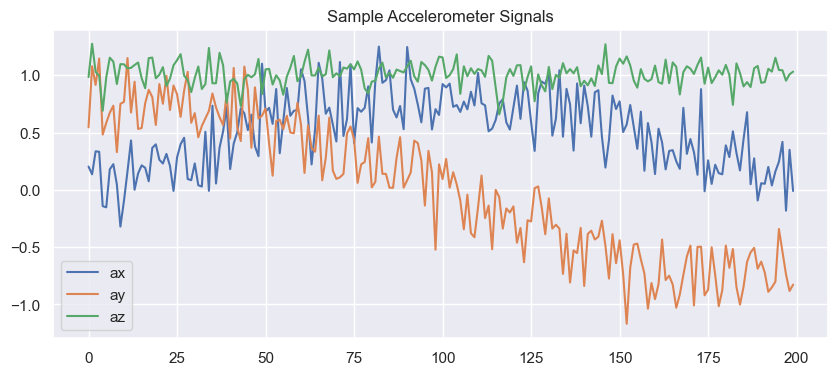

In [3]:
plt.figure(figsize=(10,4))
plt.plot(df['ax'][:200], label='ax')
plt.plot(df['ay'][:200], label='ay')
plt.plot(df['az'][:200], label='az')
plt.title('Sample Accelerometer Signals')
plt.legend()
plt.show()


## 2. Feature Extraction
Raw time-series data cannot be used directly for ML.
We convert windows of 50 samples into meaningful features such as:

- Mean  
- Standard deviation  
- Min & Max  
- Magnitude  

These features describe the motion pattern for each window.

In [4]:
WINDOW = 50
STEP = 50

def extract_features(data):
    features = []
    labels = []
    for i in range(0, len(data) - WINDOW, STEP):
        window = data.iloc[i:i+WINDOW]
        ax = window['ax'].values
        ay = window['ay'].values
        az = window['az'].values

        feats = [
            np.mean(ax), np.std(ax), np.min(ax), np.max(ax),
            np.mean(ay), np.std(ay), np.min(ay), np.max(ay),
            np.mean(az), np.std(az), np.min(az), np.max(az),
            np.mean(np.sqrt(ax*ax + ay*ay + az*az)),  # magnitude
        ]
        features.append(feats)
        labels.append(window['label'].iloc[0])

    return np.array(features), np.array(labels)

X, y = extract_features(df)
X.shape, y.shape


((47, 13), (47,))

## 3. Train Random Forest Classifier
We train a RandomForest model on the extracted features.
This model learns how each activity's feature pattern looks.

In [5]:
model = RandomForestClassifier(n_estimators=120, random_state=42)
model.fit(X, y)
y_pred = model.predict(X)
acc = accuracy_score(y, y_pred)
acc


1.0

## 4. Evaluate Model
We use a confusion matrix to visualize how well the model classifies:
- walking  
- running  
- sitting  

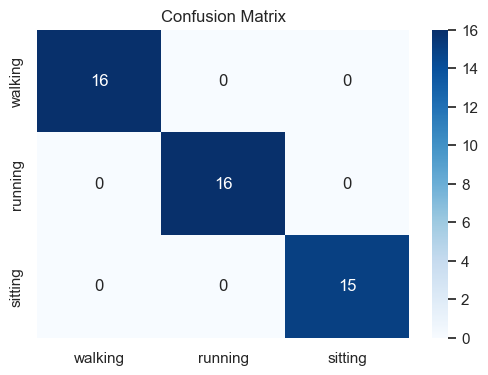

In [6]:
cm = confusion_matrix(y, y_pred, labels=['walking', 'running', 'sitting'])
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d',
            xticklabels=['walking','running','sitting'],
            yticklabels=['walking','running','sitting'],
            cmap='Blues')
plt.title('Confusion Matrix')
plt.show()


## 5. Save Model and Confusion Matrix
We save the trained model and confusion matrix for reuse in apps or demos.

In [7]:
os.makedirs('outputs', exist_ok=True)
plt.savefig('outputs/confusion_matrix.png')

os.makedirs('models', exist_ok=True)
joblib.dump(model, 'models/har_levelc_model.joblib')

print("Saved outputs/confusion_matrix.png and models/har_levelc_model.joblib")


Saved outputs/confusion_matrix.png and models/har_levelc_model.joblib


<Figure size 640x480 with 0 Axes>